<a href="https://colab.research.google.com/github/AyusheeMittal/legendary-guide/blob/master/EVA5_Session7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


Training a Classifier
=====================

This is it. You have seen how to define neural networks, compute loss and make
updates to the weights of the network.

Now you might be thinking,

What about data?
----------------

Generally, when you have to deal with image, text, audio or video data,
you can use standard python packages that load data into a numpy array.
Then you can convert this array into a ``torch.*Tensor``.

-  For images, packages such as Pillow, OpenCV are useful
-  For audio, packages such as scipy and librosa
-  For text, either raw Python or Cython based loading, or NLTK and
   SpaCy are useful

Specifically for vision, we have created a package called
``torchvision``, that has data loaders for common datasets such as
Imagenet, CIFAR10, MNIST, etc. and data transformers for images, viz.,
``torchvision.datasets`` and ``torch.utils.data.DataLoader``.

This provides a huge convenience and avoids writing boilerplate code.

For this tutorial, we will use the CIFAR10 dataset.
It has the classes: ‘airplane’, ‘automobile’, ‘bird’, ‘cat’, ‘deer’,
‘dog’, ‘frog’, ‘horse’, ‘ship’, ‘truck’. The images in CIFAR-10 are of
size 3x32x32, i.e. 3-channel color images of 32x32 pixels in size.

.. figure:: /_static/img/cifar10.png
   :alt: cifar10

   cifar10


Training an image classifier
----------------------------

We will do the following steps in order:

1. Load and normalizing the CIFAR10 training and test datasets using
   ``torchvision``
2. Define a Convolution Neural Network
3. Define a loss function
4. Train the network on the training data
5. Test the network on the test data

1. Loading and normalizing CIFAR10
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

Using ``torchvision``, it’s extremely easy to load CIFAR10.



In [1]:
%matplotlib inline

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms















The output of torchvision datasets are PILImage images of range [0, 1].
We transform them to Tensors of normalized range [-1, 1].



In [3]:
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)
if cuda:
  print(torch.cuda.device_count())
  print(torch.cuda.get_device_name(0))
device = torch.device("cuda" if cuda else "cpu")

CUDA Available? True
1
Tesla T4


In [4]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.RandomHorizontalFlip(),    
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=4)

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, **dataloader_args) #batch_size=4, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, **dataloader_args) #batch_size=4, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


Let us show some of the training images, for fun.



  car plane  ship  bird   cat horse  ship   cat
tensor(1) tensor(0) tensor(8) tensor(2) tensor(3) tensor(7) tensor(8) tensor(3)


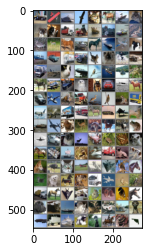

In [5]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(8)))
print(' '.join('%5s' % labels[j] for j in range(8)))

2. Define a Convolution Neural Network
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Copy the neural network from the Neural Networks section before and modify it to
take 3-channel images (instead of 1-channel images as it was defined).



In [6]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        '''
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        '''
        

        #self.convblock2 = nn.Sequential(
            #nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(5,5), padding=1, dilation=1, bias=False),
            #nn.ReLU(),
            #nn.BatchNorm2d(128)
        #) 
        self.depthwise1 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=(3,3), padding=1, dilation=1, bias=False, groups=3)
        self.pointwise1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=25, kernel_size=(1,1)),
            nn.ReLU(),
            nn.BatchNorm2d(25)
        ) 

        self.depthwise2 = nn.Conv2d(in_channels=25, out_channels=25, kernel_size=(3,3), padding=1, dilation=1, bias=False, groups=25)
        self.pointwise2 = nn.Sequential(
            nn.Conv2d(in_channels=25, out_channels=50, kernel_size=(1,1)),
            nn.ReLU(),
            nn.BatchNorm2d(50)
        )

        self.pool2 = nn.MaxPool2d(2, 2)

        #self.convblock3 = nn.Sequential(
            #nn.Conv2d(in_channels=128, out_channels=256, kernel_size=(5,5), padding=1, bias=False),
            #nn.ReLU(),
            #nn.BatchNorm2d(256)
        #) 
        self.depthwise3 = nn.Conv2d(in_channels=50, out_channels=50, kernel_size=(3,3), padding=1, dilation=1, bias=False, groups=50)
        self.pointwise3 = nn.Sequential(
            nn.Conv2d(in_channels=50, out_channels=100, kernel_size=(1,1)),
            nn.ReLU(),
            nn.BatchNorm2d(100)
        )

        self.depthwise4 = nn.Conv2d(in_channels=100, out_channels=100, kernel_size=(3,3), padding=1, dilation=1, bias=False, groups=100)
        self.pointwise4 = nn.Sequential(
            nn.Conv2d(in_channels=100, out_channels=200, kernel_size=(1,1)),
            nn.ReLU(),
            nn.BatchNorm2d(200)
        )
        
        self.pool3 = nn.MaxPool2d(2, 2)

        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=200, out_channels=500, kernel_size=(3,3), padding=1, dilation=2, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(500)
        ) 
        self.pool1 = nn.MaxPool2d(2, 2)

        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=500, out_channels=10, kernel_size=(1,1), padding=0, bias=False),
            nn.ReLU(),            
            #nn.BatchNorm2d(20)
        ) 
        
        # OUTPUT BLOCK
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=3)
        ) # output_size = 1


    def forward(self, x):

        
        #x = self.convblock2(x)
        x = self.depthwise1(x)
        x = self.pointwise1(x)
        x = self.depthwise2(x)
        x = self.pointwise2(x)
        x = self.pool2(x)
        #x = self.convblock3(x)
        x = self.depthwise3(x)
        x = self.pointwise3(x)
        x = self.depthwise4(x)
        x = self.pointwise4(x)
        x = self.pool3(x)
        x = self.convblock1(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.gap(x)
        x = x.view(-1, 10)
        return x


#net = Net()

In [7]:
!pip install torchsummary
from torchsummary import summary
model = Net().to(device)
summary(model, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 3, 32, 32]              27
            Conv2d-2           [-1, 25, 32, 32]             100
              ReLU-3           [-1, 25, 32, 32]               0
       BatchNorm2d-4           [-1, 25, 32, 32]              50
            Conv2d-5           [-1, 25, 32, 32]             225
            Conv2d-6           [-1, 50, 32, 32]           1,300
              ReLU-7           [-1, 50, 32, 32]               0
       BatchNorm2d-8           [-1, 50, 32, 32]             100
         MaxPool2d-9           [-1, 50, 16, 16]               0
           Conv2d-10           [-1, 50, 16, 16]             450
           Conv2d-11          [-1, 100, 16, 16]           5,100
             ReLU-12          [-1, 100, 16, 16]               0
      BatchNorm2d-13          [-1, 100, 16, 16]             200
           Conv2d-14          [-1, 100,

3. Define a Loss function and optimizer
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Let's use a Classification Cross-Entropy loss and SGD with momentum.



In [8]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.009, momentum=0.9)

4. Train the network
^^^^^^^^^^^^^^^^^^^^

This is when things start to get interesting.
We simply have to loop over our data iterator, and feed the inputs to the
network and optimize.



In [9]:
for epoch in range(50):  # loop over the dataset multiple times
    #total=0
    running_loss = 0.0
    for i, (data, labels) in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data.to(device), labels.to(device)
        #print(inputs.shape)
        #print(labels.shape)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        #print(outputs.shape)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        #total += labels.size(0)
        #print(total)
        #if i % 40 == 39:    # print every 2000 mini-batches
            #print('[%d, %5d] loss: %.3f' %
                  #(epoch + 1, i + 1, running_loss / 40))
            #running_loss = 0.0
    print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss))

print('Finished Training')

[1,   391] loss: 509.332
[2,   391] loss: 331.427
[3,   391] loss: 266.056
[4,   391] loss: 229.258
[5,   391] loss: 198.207
[6,   391] loss: 172.686
[7,   391] loss: 149.151
[8,   391] loss: 128.903
[9,   391] loss: 111.443
[10,   391] loss: 93.590
[11,   391] loss: 80.494
[12,   391] loss: 66.934
[13,   391] loss: 53.392
[14,   391] loss: 44.564
[15,   391] loss: 34.579
[16,   391] loss: 27.636
[17,   391] loss: 21.805
[18,   391] loss: 15.962
[19,   391] loss: 11.175
[20,   391] loss: 7.694
[21,   391] loss: 6.786
[22,   391] loss: 4.845
[23,   391] loss: 3.390
[24,   391] loss: 2.449
[25,   391] loss: 1.892
[26,   391] loss: 1.560
[27,   391] loss: 1.297
[28,   391] loss: 1.139
[29,   391] loss: 0.998
[30,   391] loss: 0.934
[31,   391] loss: 0.867
[32,   391] loss: 0.781
[33,   391] loss: 0.736
[34,   391] loss: 0.667
[35,   391] loss: 0.647
[36,   391] loss: 0.588
[37,   391] loss: 0.574
[38,   391] loss: 0.534
[39,   391] loss: 0.511
[40,   391] loss: 0.502
[41,   391] loss: 0.4

5. Test the network on the test data
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

We have trained the network for 2 passes over the training dataset.
But we need to check if the network has learnt anything at all.

We will check this by predicting the class label that the neural network
outputs, and checking it against the ground-truth. If the prediction is
correct, we add the sample to the list of correct predictions.

Okay, first step. Let us display an image from the test set to get familiar.



GroundTruth:    car truck plane   dog   dog  ship plane   car  deer  bird   cat  frog  deer   dog horse truck truck  frog  frog   car   dog   cat  bird  deer plane  ship  bird  bird  bird  deer truck  frog  frog   car  ship  frog  deer  ship  bird  ship horse plane horse horse horse  deer  bird  frog   cat truck   cat  frog  deer truck   cat   car  bird  deer  frog  bird  ship  deer   cat  ship  ship   car  frog horse   dog   dog  bird truck plane  bird  frog  deer   car plane horse   car horse truck   car   dog plane horse   car horse truck  deer plane plane  ship  ship  ship truck plane  frog   car  ship horse truck plane  deer horse  bird  deer   cat   car  frog truck horse truck  deer  frog   dog truck   dog horse plane  bird   cat  bird   cat   car  deer   dog   car


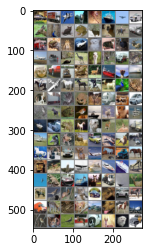

In [10]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(128)))

Okay, now let us see what the neural network thinks these examples above are:



In [11]:
outputs = model(images.to(device))

The outputs are energies for the 10 classes.
Higher the energy for a class, the more the network
thinks that the image is of the particular class.
So, let's get the index of the highest energy:



In [12]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(128)))

Predicted:    car truck plane  bird  deer  ship plane   car  bird  bird   cat  frog  deer   dog horse truck truck  frog  frog   car   dog   cat  bird  deer plane  ship  bird  bird  bird  deer truck  frog  frog   car  ship  frog  deer  ship  bird  ship horse plane horse horse horse horse  bird  frog   dog truck   cat   dog  deer truck   dog   car  frog  bird  frog  bird  ship  deer   cat  ship  ship   car  frog horse   dog  deer  bird truck plane  bird  frog  deer   car plane   dog  ship horse truck   car  deer plane truck   car horse truck  deer truck plane  ship  ship  ship truck  bird  frog   car  ship horse truck  ship  deer horse  deer   cat   cat   car  frog   car horse truck  deer  frog   dog truck   cat horse plane  bird   cat  bird   cat   car  deer   dog truck


The results seem pretty good.

Let us look at how the network performs on the whole dataset.



In [13]:
correct = 0
total = 0
test_loss = 0
running_loss = 0
with torch.no_grad():
    for data, label in testloader:
        images, labels = data.to(device), label.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        test_loss = criterion(outputs, labels) 
        running_loss += test_loss.item()

print('Accuracy of the network on the 10000 test images: %d %%, Test loss:' % (
    100 * correct / total), running_loss)

Accuracy of the network on the 10000 test images: 82 %, Test loss: 59.665302991867065


That looks waaay better than chance, which is 10% accuracy (randomly picking
a class out of 10 classes).
Seems like the network learnt something.

Hmmm, what are the classes that performed well, and the classes that did
not perform well:



In [14]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data, label in testloader:
        images, labels = data.to(device), label.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 92 %
Accuracy of   car : 96 %
Accuracy of  bird : 77 %
Accuracy of   cat : 68 %
Accuracy of  deer : 63 %
Accuracy of   dog : 71 %
Accuracy of  frog : 88 %
Accuracy of horse : 96 %
Accuracy of  ship : 86 %
Accuracy of truck : 93 %
